In [7]:
import matplotlib.gridspec as gridspec
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

In [11]:
Antibody_dissociation = 15              #(units = nM) Dissociation constant of antibody in nM
Concentration_of_Antibody = 1           #(units = nM) Used for the Kinetic Simulation
number_of_receptors_per_Tcell = 100000  #(units = molecules per cell) Receptors per T cell
number_of_receptors_per_tumor = 100000  #(units = molecules per cell) Receptors per Tumor cell

alpha = 10                              #Cooperativity rate 
#####   Cooperativity   #####
# (0 to 1)  is negative cooperativity
# (1)       is no cooperativitiy
# (1 to inifinity) is positive cooperativity

#Variables given for the experimental situation
Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
reaction_volume = 150                                    #150 uL reaction volume
number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
number_of_tumor_cells = 400000                           #400,000 Tumor Cells in reaction      

#Calculating the initial molecular concentrations
Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume)
Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume)

#Calculating the kinetic parameters - since we only have equilibrium data, we are interested in ratios, not the rates themselves
k_binding_snap_to_antibody = 1                          #Assumes quick binding for simulation
k_release_snap_to_antibody = 0                          #No release due to covalent bond
k_binding_antibody_to_tumor = 1                         #Assumes quick binding for simulation

#The following reaction rate accounts for the nM units of user input
k_release_antibody_to_tumor = k_binding_antibody_to_tumor * Antibody_dissociation * 10**-9 
k_cooperativity_binding_snap = k_binding_snap_to_antibody * alpha       #Accounts for Cooperativity
k_cooperativity_releasing_snap = k_release_snap_to_antibody * alpha     #Accounts for Cooperativity
k_cooperativity_binding_tumor = k_binding_antibody_to_tumor * alpha     #Accounts for Cooperativity
k_cooperativity_releasing_tumor = k_release_antibody_to_tumor * alpha   #Accounts for Cooperativity

#Saving the variables for simulation
k = [k_binding_snap_to_antibody,k_release_snap_to_antibody,k_binding_antibody_to_tumor,k_release_antibody_to_tumor,k_cooperativity_binding_snap,k_cooperativity_releasing_snap,k_cooperativity_binding_tumor,k_cooperativity_releasing_tumor]
Initial = [Concentration_of_T_Cells,Concentration_of_Antibody,Concentration_of_Tumor_Cells,0,0,0]
time = np.linspace(0,10,1000)

In [12]:
def rxn(C,t):
    #Loading the global variable reaction rates
    kf1 = k[0]                                             
    kr1 = k[1]                                             
    kf2 = k[2]                                             
    kr2 = k[3]                                             
    kf3 = k[4]                                             
    kr3 = k[5]                                             
    kf4 = k[6]                                             
    kr4 = k[7]        
    
    #Loading the initial concentrations
    C_snap = C[0]                   #initial concentration of free T Cell receptor
    C_anti = C[1]                   #initial concentration of free antibody
    C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
    C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
    C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
    C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
    
    #Separation of key equation terms for simplicity
    term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody                              
    term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
    term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
    term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
    term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
    term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
    term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
    term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body
    
    #ODEs that model the dynamic change in concentration of each chemical species
    d_C_snap_dt = - term1 + term2 - term7 + term8           #change in free T Cell receptor
    d_C_anti_dt = - term1 + term2 - term3 + term4           #change in free antibody
    d_C_tumo_dt = - term3 + term4 - term5 + term6           #change in free Tumor cell receptor
    d_C_snap_anti_dt = + term1 - term2 - term5 + term6      #change in bound T Cell - Antibody
    d_C_anti_tumo_dt = + term3 - term4 - term7 + term8      #change in bound Tumor Cell - Antibody
    d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8 #change in Ternary Body
    
    return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])

### Simulation and Plotting Equilibrium Concentrations over a Range of Antibody Release Rates

In this analysis, we simulate the same situation as above but varying the antibody unbinding rate. We will be scanning a logarithmic space from 10e-12 to 10e-6. Please note that the analysis above took place at Kd of 15 * 10e-9 (or 15 nM).

In [13]:
data = []
dissociation_range = np.logspace(-1,2,num=10, endpoint=True, base=10.0)
for dissociation_rate in dissociation_range:
    Antibody_dissociation = 15
    #Calculating the Kinetic Parameters - since we only have equilibrium data, we are interested in ratios, not numbers
    k_binding_snap_to_antibody = 10**-0                      #
    k_release_snap_to_antibody = dissociation_rate  #Scanning the dissociation rate
    k_binding_antibody_to_tumor = 10**-0#
    k_release_antibody_to_tumor = k_binding_antibody_to_tumor * Antibody_dissociation * 10**-9
    print(k_release_snap_to_antibody)
    k_cooperativity_binding_snap = k_binding_snap_to_antibody * alpha
    k_cooperativity_releasing_snap = k_release_snap_to_antibody * alpha
    k_cooperativity_binding_tumor = k_binding_antibody_to_tumor * alpha
    k_cooperativity_releasing_tumor = k_release_antibody_to_tumor * alpha
    k = [k_binding_snap_to_antibody,k_release_snap_to_antibody,k_binding_antibody_to_tumor,k_release_antibody_to_tumor,k_cooperativity_binding_snap,k_cooperativity_releasing_snap,k_cooperativity_binding_tumor,k_cooperativity_releasing_tumor]
    
    N = 100
    antibody_range = np.logspace(-3,1,N)
    ternary_body = []
    for i in antibody_range:
        Initial[1] = i
        C = odeint(rxn,Initial,time)
        ternary_body.append(float((C[100,5])))
    data.append(ternary_body)

0.1
0.21544346900318834
0.46415888336127786
1.0
2.1544346900318834
4.6415888336127775
10.0
21.54434690031882
46.41588833612777
100.0


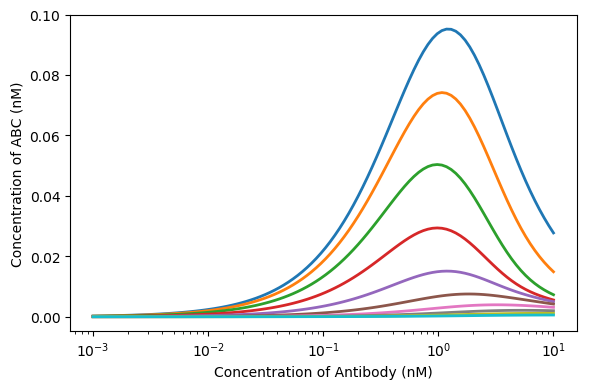

In [14]:
fig = plt.figure(figsize=(6, 4), dpi=100)

gs1 = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs1[0])
for i in range(0,10):
    ax.plot(antibody_range,data[i],linewidth=2.0)
    
# ax.plot(antibody_range,data[0],linewidth=2.0)
# ax.plot(antibody_range,data[1],linewidth=2.0)
# ax.plot(antibody_range,data[2],linewidth=2.0)
# ax.plot(antibody_range,data[3],linewidth=2.0)
# ax.plot(antibody_range,data[4],linewidth=2.0)
# ax.plot(antibody_range,data[5],linewidth=2.0)
# ax.plot(antibody_range,data[6],linewidth=2.0)

plt.xlabel('Concentration of Antibody (nM)')
plt.ylabel('Concentration of ABC (nM)')
plt.xscale("log")
# ax.legend(['Kd = 15 nM'])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
# ax.legend(['Kd = 10e-12','Kd = 10e-11','Kd = 10e-10','Kd = 10e-9','Kd = 10e-8','Kd = 10e-7','Kd = 10e-6'],loc='center left', bbox_to_anchor=(1, 0.5))

gs1.tight_layout(fig)
gs1.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('Graph1.png')
plt.show()